In [1]:
!pip install tensorflow matplotlib


zsh:1: command not found: pip


In [2]:
# =====================================
#  DOWNLOAD ZIP FILE FROM GOOGLE DRIVE
# ======================================
!pip install gdown

file_id = "1OoTWKwfxY_3NW0-ge5_LECK1Uaoo9lcO"   # your ZIP ID
zip_path = "dataset.zip"

print("Downloading dataset.zip...")
!gdown --id {file_id} -O {zip_path}

# ====================
#  UNZIP THE DATASET
# =====================
import zipfile

print("Extracting...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset_extracted")

print("Extraction Completed!")
# ===============================================
#  AUTO-DETECT DATASET DIRECTORY
#   Find folder that contains train/valid/test
# ==============================================
import os

dataset_root = "dataset_extracted"
dataset_dir = None

for root, dirs, files in os.walk(dataset_root):
    if set(dirs) & {"train", "valid", "test"}:
        dataset_dir = root
        break

if dataset_dir is None:
    raise Exception("Could not find train/valid/test folder inside ZIP!")

print("Dataset directory detected:", dataset_dir)

train_dir = os.path.join(dataset_dir, "train")
valid_dir = os.path.join(dataset_dir, "valid")
test_dir  = os.path.join(dataset_dir, "test")

print("Train:", train_dir)
print("Valid:", valid_dir)
print("Test :", test_dir)


zsh:1: command not found: pip
zsh:1: command not found: gdown
Extracting...


FileNotFoundError: [Errno 2] No such file or directory: 'dataset.zip'

In [ ]:
!pip install torch torchvision torchcam seaborn

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask


# ===============
#  DEFINE CNN
# ===============
class AutismCNN(nn.Module):
    def __init__(self):
        super(AutismCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2,2)

        # 224 → 112 → 56 → 28  (after 3 pools)
        self.fc1 = nn.Linear(128*28*28, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 2)  # 2 classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # logits



In [ ]:

# =================
#  DATA LOADERS
# =================
DATA_ROOT = "dataset_extracted"

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tf)
valid_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "valid"), transform=test_tf)
test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

class_names = train_ds.classes
print("Classes:", class_names)


# =================================
#  SETUP MODEL, LOSS, OPTIMIZER
# =================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutismCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Classes: ['autistic', 'non_autistic']


In [ ]:

# ===================
#  TRAINING LOOP
# ===================
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()

            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(y.cpu().numpy())

    return total_loss / len(loader.dataset), correct / len(loader.dataset), preds_all, labels_all


# TRAIN
EPOCHS = 10
train_accs = []
val_accs = []
train_lossarr = []
val_lossarr = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc, _, _ = eval_epoch(valid_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_lossarr.append(train_loss)
    val_lossarr.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Loss {train_loss:.4f} Acc {train_acc:.4f} "
          f"| Val Loss {val_loss:.4f} Acc {val_acc:.4f}")


Epoch 1/10 | Train Loss 0.6635 Acc 0.5942 | Val Loss 0.6350 Acc 0.5800
Epoch 2/10 | Train Loss 0.5987 Acc 0.6719 | Val Loss 0.5547 Acc 0.6800
Epoch 3/10 | Train Loss 0.5664 Acc 0.7019 | Val Loss 0.5449 Acc 0.7300
Epoch 4/10 | Train Loss 0.5479 Acc 0.7145 | Val Loss 0.5297 Acc 0.7200
Epoch 5/10 | Train Loss 0.5392 Acc 0.7252 | Val Loss 0.5106 Acc 0.7000
Epoch 6/10 | Train Loss 0.5230 Acc 0.7362 | Val Loss 0.5037 Acc 0.7000
Epoch 7/10 | Train Loss 0.5063 Acc 0.7449 | Val Loss 0.5895 Acc 0.6600
Epoch 8/10 | Train Loss 0.5097 Acc 0.7374 | Val Loss 0.5161 Acc 0.7300
Epoch 9/10 | Train Loss 0.4955 Acc 0.7547 | Val Loss 0.4630 Acc 0.7700
Epoch 10/10 | Train Loss 0.4809 Acc 0.7701 | Val Loss 0.4551 Acc 0.7500


In [ ]:
torch.save(model.state_dict(), "autism_cnn.pth")
print("Model saved as autism_cnn.pth")

Model saved as autism_cnn.pth



Test Accuracy: 0.7833333333333333

Classification Report:
              precision    recall  f1-score   support

    autistic       0.75      0.84      0.79       150
non_autistic       0.82      0.73      0.77       150

    accuracy                           0.78       300
   macro avg       0.79      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300



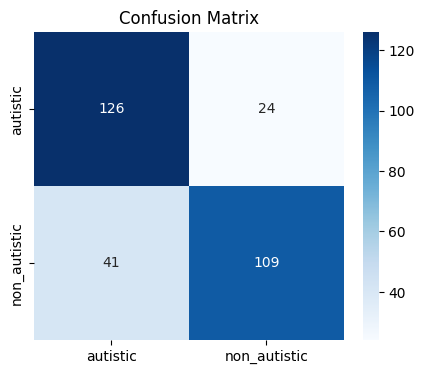

In [ ]:
# ======================
#  TEST EVALUATION
# ======================
test_loss, test_acc, y_pred, y_true = eval_epoch(test_loader)
print("\nTest Accuracy:", test_acc)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()



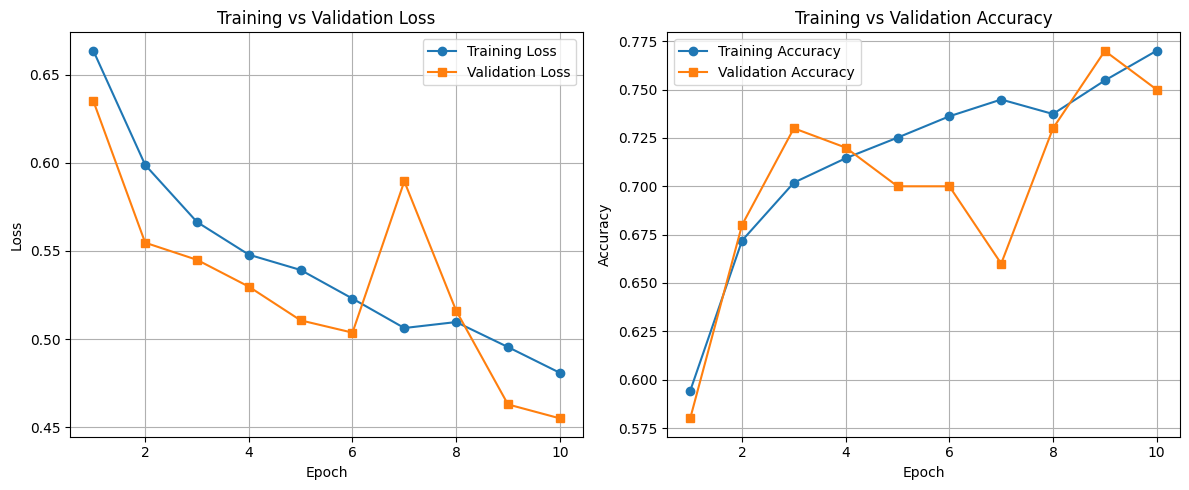

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,5))

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, train_lossarr, marker='o', label='Training Loss')
plt.plot(epochs, val_lossarr, marker='s', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accs, marker='s', label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

# ======================
#  SmoothGrad-CAM++
# ======================
# Only last conv layer must require grad
for name, param in model.named_parameters():
    if "conv3" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.eval()

cam_extractor = SmoothGradCAMpp(model)  # attach hooks


def smoothgrad_campp(image_path):
    pil_img = Image.open(image_path).convert("RGB").resize((224,224))
    img_tensor = test_tf(pil_img).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad = True

    logits = model(img_tensor)
    pred_class = logits.argmax(1).item()

    # CAM++
    cams = cam_extractor(pred_class, logits)
    cam = cams[0][0].detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam /= cam.max() + 1e-8

    heatmap_uint8 = (cam * 255).astype(np.uint8)
    heatmap_pil = Image.fromarray(heatmap_uint8).resize((224,224))

    overlay = overlay_mask(pil_img, heatmap_pil, alpha=0.5)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(pil_img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title("SmoothGrad-CAM++"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()



Running CAM on: dataset_extracted/test/autistic/055.jpg


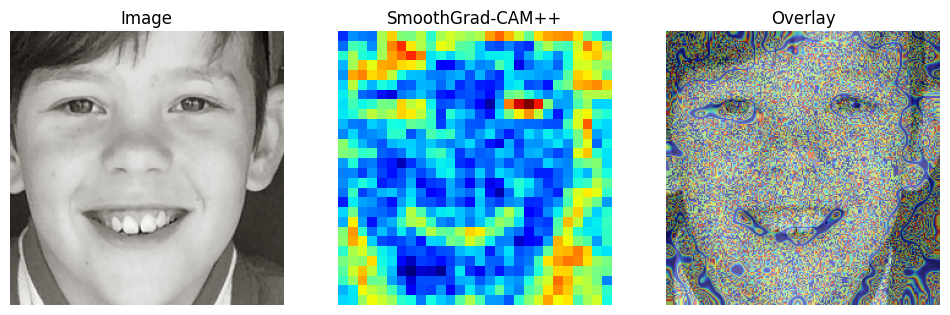


Running CAM on: dataset_extracted/test/non_autistic/055.jpg


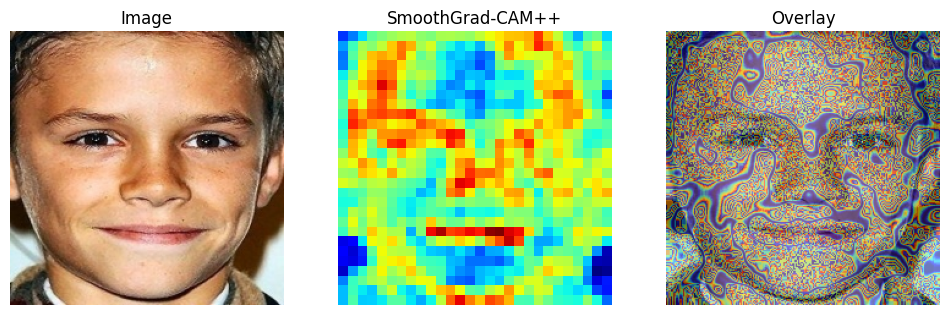

In [ ]:

# ================================
#  RUN SGCAM++ ON SAMPLE IMAGES
# ================================
test_autistic = os.path.join(DATA_ROOT,"test","autistic")
test_non = os.path.join(DATA_ROOT,"test","non_autistic")

sample_imgs = [
    os.path.join(test_autistic, os.listdir(test_autistic)[0]),
    os.path.join(test_non, os.listdir(test_non)[0])
]

for p in sample_imgs:
    print("\nRunning CAM on:", p)
    smoothgrad_campp(p)
